In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import sys

import pandas as pd
import numpy as np
from pathlib import Path
import yaml
from typing import *
import glob

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, DataFrame, Window
import itertools

from saturation.utils import *

pio.renderers.default = "iframe"

In [5]:
n_cores = 28

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "60g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

24/04/14 15:38:59 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.86.20 instead (on interface enp8s0)
24/04/14 15:38:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/14 15:38:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/14 15:39:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/04/14 15:39:00 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [6]:
base_path = "/data/saturation/thesis_run_20240130"
study_region_size = 4000
r_stat = 5
study_region_padding = int(study_region_size * 0.125)

In [7]:
configs_df = create_configs_df(read_configs(base_path, spark))
configs_pd = configs_df.toPandas()

In [8]:
configs_pd[configs_pd.slope.between(2.7, 2.8)].sort_values("slope")

,effective_radius_multiplier,min_rim_percentage,r_stat_multiplier,simulation_id,slope
9207,1.450640,0.317497,9.230911,204,2.700036
987,1.164508,0.264163,12.653650,2419,2.700196
3774,1.260481,0.474409,14.173195,725,2.700208
8341,1.533356,0.402474,6.008638,6930,2.700491
7921,1.419263,0.372001,7.509564,6277,2.700559
...,...,...,...,...,...
9307,1.869408,0.430136,9.830555,7078,2.799143
5446,1.344546,0.699171,8.976379,669,2.799165
5417,1.785421,0.258385,13.133549,5407,2.799456
426,1.360024,0.357949,10.322456,9267,2.799780


In [9]:
configs_dict = dict()
for config_file in glob.glob(f"{base_path}/config/config_*.yaml"):
    for run_config in read_config(Path(config_file))["run_configurations"]:
        configs_dict.update(run_config)

## Example CSFD

estimated slope=-2.676, sigma=0.054


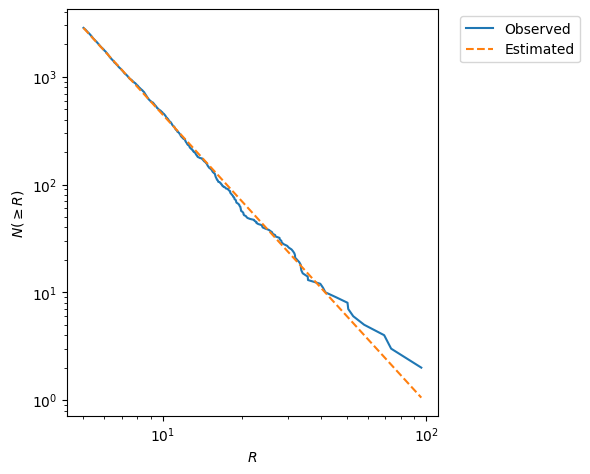

In [10]:
# Steep slope, 2.7
simulation_id = 6930
target_n_craters_added_in_study_region = 3000
est_saturation_n = 40

sim_name = configs_dict[simulation_id]["simulation_name"]
sim_path = f"{base_path}/{sim_name}"

stats_df = spark.read.parquet(f"{sim_path}/statistics_*.parquet")
craters_df = spark.read.parquet(f"{sim_path}/craters_*.parquet")
removals_df = spark.read.parquet(f"{sim_path}/crater_removals_*.parquet")

state = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding,
    spark
)   

estimated_slope, sigma = estimate_cumulative_slope(state.radius,
                                                   state.radius.min(),
                                                   est_saturation_n)
intercept = estimate_intercept(state.radius[state.radius < est_saturation_n], estimated_slope)
print(f"estimated slope={estimated_slope:.3f}, sigma={sigma:.3f}")
plot_sfds(state, -estimated_slope, intercept=intercept)

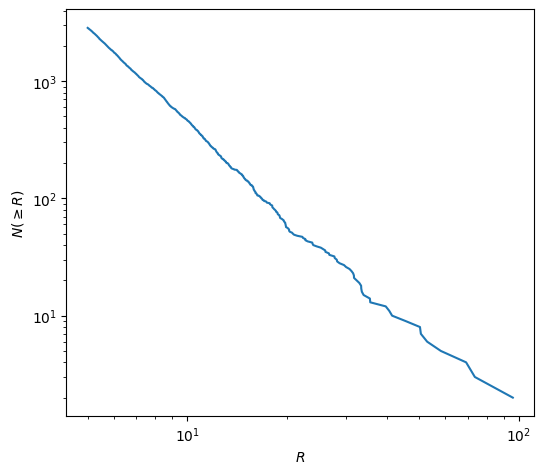

In [12]:
# Plotting just the CSFD
radii = state.radius.sort_values()

# Track min and max radii
min_radius = radii.min()
max_radius = radii.max()

plt.plot(radii, range(len(radii) + 1, 1, -1), label="Observed")
plt.xlabel("$R$")
plt.ylabel("$N(\geq R)$")

plt.subplots_adjust(right=0.7)
plt.tight_layout(rect=[0, 0, 0.9, 1])

plt.xscale('log')
plt.yscale('log')
plt.savefig("figures/example_csfd.png")

plt.show()

## Shallow slope

In [19]:
configs_pd[configs_pd.slope.between(1.0, 1.1)].sort_values("min_rim_percentage")

,effective_radius_multiplier,min_rim_percentage,r_stat_multiplier,simulation_id,slope
6239,1.845613,0.250027,14.228410,6762,1.079790
8735,1.657225,0.251103,9.476871,6658,1.016926
7359,1.855791,0.253062,12.162142,9734,1.046824
4815,1.360745,0.253735,13.434216,3050,1.005377
4242,1.441973,0.253944,10.581036,8802,1.071319
...,...,...,...,...,...
4142,1.868234,0.748879,8.599029,4046,1.088105
7893,1.833388,0.749186,12.438455,2606,1.006278
5669,1.319789,0.749605,6.872882,5695,1.098544
5372,1.475330,0.749869,9.362845,2221,1.047520


estimated slope=-1.028, sigma=0.068


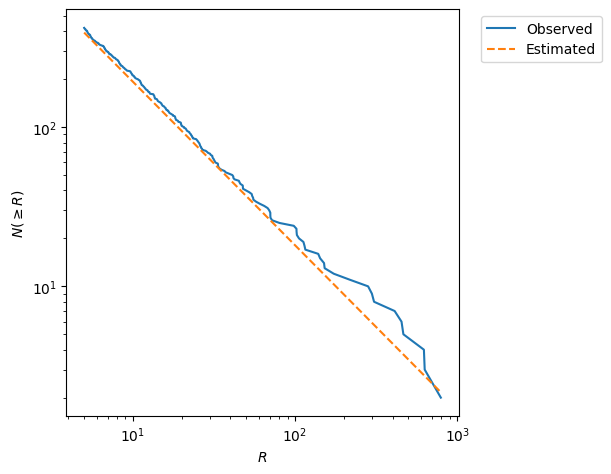

In [28]:
# Shallow slope, 1.0
simulation_id = 3050
target_n_craters_added_in_study_region = 300000
est_saturation_n = 125

sim_name = configs_dict[simulation_id]["simulation_name"]
sim_path = f"{base_path}/{sim_name}"

stats_df = spark.read.parquet(f"{sim_path}/statistics_*.parquet")
craters_df = spark.read.parquet(f"{sim_path}/craters_*.parquet")
removals_df = spark.read.parquet(f"{sim_path}/crater_removals_*.parquet")

state = get_state_at_time(
    stats_df,
    craters_df,
    removals_df,
    simulation_id,
    target_n_craters_added_in_study_region,
    study_region_size,
    study_region_padding,
    spark
)   

estimated_slope, sigma = estimate_cumulative_slope(state.radius,
                                                   state.radius.min(),
                                                   est_saturation_n)
intercept = estimate_intercept(state.radius[state.radius < est_saturation_n], estimated_slope)
print(f"estimated slope={estimated_slope:.3f}, sigma={sigma:.3f}")
plot_sfds(state, -estimated_slope, intercept=intercept)

estimated slope=-0.208, sigma=0.486


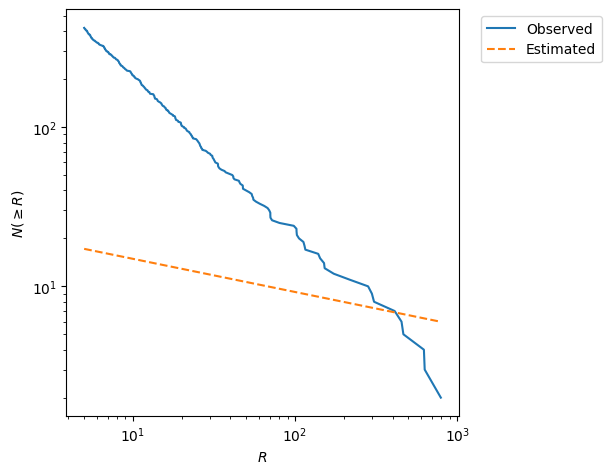

In [29]:
estimated_slope, sigma = estimate_cumulative_slope(state.radius,
                                                   est_saturation_n,
                                                   state.radius.max())
intercept = estimate_intercept(state.radius[state.radius > est_saturation_n], estimated_slope)
print(f"estimated slope={estimated_slope:.3f}, sigma={sigma:.3f}")
plot_sfds(state, -estimated_slope, intercept=intercept)

In [31]:
state[state.radius > 200]

,x,y,radius
80,2340.401611,1817.565063,792.887329
193,3987.651123,4332.824219,623.603027
200,1361.613159,4436.165527,411.585419
224,1881.941162,2445.929688,282.421021
300,1561.367676,1327.718018,453.872131
336,2054.354004,4419.251465,307.336334
341,1957.212646,1725.835815,298.016510
356,2927.408447,593.381958,218.096008
396,1012.393250,1187.112793,465.999390
418,2208.605469,3821.570068,630.567261
